## Predicting Loan Interests

In [1]:
# import modules 
import pandas as pd
import numpy as np
from datetime import datetime

import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

In [2]:
%matplotlib inline

In [3]:
# load data
loan = pd.read_csv("Data for Cleaning & Modeling.csv", dtype={'X15': object})

/Users/Joy/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


### Preprocess Data

#### 1. Define Column Names

In [4]:
# rename columns
col = pd.read_csv("Metadata.csv")
col_cor = dict(zip(col["Variable"], col["Definition"]))
loan = loan.rename(columns = col_cor)

loan = loan.rename(columns = {"Interest Rate on the loan" : "interest_rate",
                              "A unique id for the loan." : "loan_id",
                              "A unique id assigned for the borrower." : "borrower_id",
                              "Loan amount requested" : "loan_amount_requested",
                              "Loan amount funded" : "loan_amount_funded",
                              "Investor-funded portion of loan" : "investor-funded_portion_of_loan",
                              "Number of payments (36 or 60)" : "number_of_payments",
                              "Loan grade" : "loan_grade",
                              "Loan subgrade" : "loan_subgrade",
                              "Employer or job title (self-filled)" : "employer/job_title",
                              "Number of years employed (0 to 10; 10 = 10 or more)" : "years_employed",
                              "Home ownership status: RENT, OWN, MORTGAGE, OTHER." : "home_ownership_status",
                              "Annual income of borrower" : "borrower's_annual_income",
                              "Income verified, not verified, or income source was verified" : "income_verified",
                              "Date loan was issued" : "issue_month",
                              "Reason for loan provided by borrower" : "reason_for_borrowing",
                              "Loan category, as provided by borrower" : "loan_category",
                              "Loan title, as provided by borrower" : "loan_title",
                              "First 3 numbers of zip code" : "zipcode_first3",
                              "State of borrower" : "state_of_borrower",
                              "A ratio calculated using the borrower�۪s total monthly debt payments on the total debt obligations, excluding mortgage and the requested loan, divided by the borrower�۪s self-reported monthly income." : "debt_ratio",
                              "The number of 30+ days past-due incidences of delinquency in the borrower's credit file for the past 2 years" : "num_of_past-dues",
                              "Date the borrower's earliest reported credit line was opened" : "credit-line_open_date",
                              "Number of inquiries by creditors during the past 6 months." : "num_of_inquiries",
                              "Number of months since the borrower's last delinquency." : "month_since_last_delinquency",
                              "Number of months since the last public record." : "duration_of_public_record",
                              "Number of open credit lines in the borrower's credit file." : "open_credit-lines",
                              "Number of derogatory public records" : "derogatory_records",
                              "Total credit revolving balance" : "revolving_balance",
                              "Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit." : "revolving_ratio",
                              "The total number of credit lines currently in the borrower's credit file" : "total_credit-lines",
                              "The initial listing status of the loan. Possible values are ��� W, F" : "initial_status" })

In [5]:
loan.columns

Index(['interest_rate', 'loan_id', 'borrower_id', 'loan_amount_requested',
       'loan_amount_funded', 'investor-funded_portion_of_loan',
       'number_of_payments', 'loan_grade', 'loan_subgrade',
       'employer/job_title', 'years_employed', 'home_ownership_status',
       'borrower's_annual_income', 'income_verified', 'issue_month',
       'reason_for_borrowing', 'loan_category', 'loan_title', 'zipcode_first3',
       'state_of_borrower', 'debt_ratio', 'num_of_past-dues',
       'credit-line_open_date', 'num_of_inquiries',
       'month_since_last_delinquency', 'duration_of_public_record',
       'open_credit-lines', 'derogatory_records', 'revolving_balance',
       'revolving_ratio', 'total_credit-lines', 'initial_status'],
      dtype='object')

#### 2. Drop Duplicated Features

Assume that **loan_id** and **borrower_id**, and **credit-line_open_date** has little predictive power to interest rate. Drop them.

In [6]:
# drop loan_id, borrower_id
loan = loan.drop(columns=["loan_id", "borrower_id", "credit-line_open_date"])

**loan_grade** is a subset of **loan_subgrade** and two variables are repetitive. Keep only the more informative one - **loan_subgrade**, because different loan_subgrades may result in different interest rates.

In [7]:
# drop loan_grade
loan = loan.drop(columns=["loan_grade"])

**loan_title** has 61,630 unique values (~15% of the total data), each of which is irregular. Meanwhile, **loan_category** has 14 unique values and the contents are as intuitive as loan_title. Thus drop loan_title.

In [8]:
# drop loan_grade
loan = loan.drop(columns=["loan_title"])

**reason_for_borrowing** needs text processing, which will not be covered for this exercise. **loan_category** reveals similar information to this variable.

In [9]:
# drop loan_grade
loan = loan.drop(columns=["reason_for_borrowing"])

**First three digits of zip code** gives more granularity on area but its distribution also becomes more skewed. For this reason, keep **state_of_borrower** instead. 

In [10]:
# drop zipcode
loan = loan.drop(columns=["zipcode_first3"])

**duration_of_public_record** has ~87% missing values. Drop the column.

In [11]:
# drop duration_of_public_record
loan = loan.drop(columns=["duration_of_public_record"])

**open_credit-lines** and **total_credit-lines** are all about credit lines owned by borrower. Keep only the former variable, which records most recent information.

In [12]:
# drop total_credit-lines
loan = loan.drop(columns=["total_credit-lines"])

In [13]:
loan.shape

(400000, 23)

#### 3. Correct Data Types

In [14]:
pd.set_option('display.max_columns', None)
loan.head()

,interest_rate,loan_amount_requested,loan_amount_funded,investor-funded_portion_of_loan,number_of_payments,loan_subgrade,employer/job_title,years_employed,home_ownership_status,borrower's_annual_income,income_verified,issue_month,loan_category,state_of_borrower,debt_ratio,num_of_past-dues,num_of_inquiries,month_since_last_delinquency,open_credit-lines,derogatory_records,revolving_balance,revolving_ratio,initial_status
0,11.89%,"$25,000","$25,000","$19,080",36 months,B4,NaN,< 1 year,RENT,85000.0,VERIFIED - income,Aug-09,debt_consolidation,CA,19.48,0.0,0.0,NaN,10.0,0.0,28854.0,52.10%,f
1,10.71%,"$7,000","$7,000",$673,36 months,B5,CNN,< 1 year,RENT,65000.0,not verified,May-08,credit_card,NY,14.29,0.0,0.0,NaN,7.0,0.0,33623.0,76.70%,f
2,16.99%,"$25,000","$25,000","$24,725",36 months,D3,Web Programmer,1 year,RENT,70000.0,VERIFIED - income,Aug-14,debt_consolidation,NY,10.50,0.0,0.0,41.0,10.0,0.0,19878.0,66.30%,f
3,13.11%,"$1,200","$1,200","$1,200",36 months,C2,city of beaumont texas,10+ years,OWN,54000.0,not verified,Mar-10,debt_consolidation,TX,5.47,0.0,0.0,64.0,5.0,0.0,2584.0,40.40%,f
4,13.57%,"$10,800","$10,800","$10,692",36 months,C3,State Farm Insurance,6 years,RENT,32000.0,not verified,Nov-09,debt_consolidation,CT,11.63,0.0,1.0,58.0,14.0,0.0,3511.0,25.60%,f


In [15]:
# interest_rate: change label to natural number
loan["interest_rate"] = loan["interest_rate"].str.replace("%", "")
loan["interest_rate"] = loan["interest_rate"].astype(dtype="float64")

In [16]:
# loan_amount_requested: str to float
loan["loan_amount_requested"] = loan["loan_amount_requested"].str.replace("\$", "", regex=True).replace(",", "", regex=True)
loan["loan_amount_requested"] = loan["loan_amount_requested"].astype(dtype="float")

# loan_amount_funded: str to float
loan["loan_amount_funded"] = loan["loan_amount_funded"].str.replace("\$", "", regex=True).replace(",", "", regex=True)
loan["loan_amount_funded"] = loan["loan_amount_funded"].astype(dtype="float")

# investor-funded_portion_of_loan: str to float
loan["investor-funded_portion_of_loan"] = loan["investor-funded_portion_of_loan"].str.replace("\$", "", regex=True).replace(",", "", regex=True)
loan["investor-funded_portion_of_loan"] = loan["investor-funded_portion_of_loan"].astype(dtype="float")

# number_of_payments: str to float
loan["number_of_payments"] = loan["number_of_payments"].str.replace(" months", "", regex=True)
loan["number_of_payments"] = loan["number_of_payments"].astype(dtype="float")

# years_employed: str to float
loan["years_employed"] = loan["years_employed"].str.replace(" years", "", regex=True).replace(" year", "", regex=True).replace("< 1", "0", regex=True)
loan["years_employed"] = loan["years_employed"].replace("10\+", "10", regex=True)
loan["years_employed"] = loan["years_employed"].astype(dtype="float")


In [17]:
# income_verified: str to dummy
loan["income_verified"] = loan["income_verified"].str.replace("VERIFIED - income", "verified", regex=True).replace("VERIFIED - income source", "verified", regex=True)
loan["income_verified"] = loan["income_verified"].apply(lambda x: 1 if x=="verified" else 0)

# loan_subgrade: str to ordinary 
scale_mapper = {"A1":35, "A2":34, "A3":33, "A4":32, "A5":31,
                "B1":30, "B2":29, "B3":28, "B4":27, "B5":26,
                "C1":25, "C2":24, "C3":23, "C4":22, "C5":21,
                "D1":20, "D2":19, "D3":18, "D4":17, "D5":16,
                "E1":15, "E2":14, "E3":13, "E4":12, "E5":11,
                "F1":10, "F2":9, "F3":8, "F4":7, "F5":6,
                "G1":5, "G2":4, "G3":3, "G4":2, "G5":1,}
loan["loan_subgrade"] = loan["loan_subgrade"].replace(scale_mapper)

# loan_category: str to dummies (keep the top two classes: debt_consolidation & credit_card)
loan["loan_for_debt_consolidation"] = loan["loan_category"].apply(lambda x: 1 if x == "debt_consolidation" else 0)
loan["loan_for_credit_card"] = loan["loan_category"].apply(lambda x: 1 if x == "credit_card" else 0)
loan = loan.drop(columns=["loan_category"])


There is one record wiht **home_ownership_status** being "ANY," which does not make sense and could be an recording error.

In [18]:
# drop exceptional row
ex = loan[loan["home_ownership_status"]=="ANY"]
loan = loan.drop(ex.index)

# home_ownership_status: str to dummies (keep the top two classes: MORTGAGE & RENT) 
loan["home_is_MORTGAGE"] = loan["home_ownership_status"].apply(lambda x: 1 if x == "MORTGAGE" else 0)
loan["home_is_RENT"] = loan["home_ownership_status"].apply(lambda x: 1 if x == "RENT" else 0)
loan = loan.drop(columns=["home_ownership_status"])


In [19]:
# issue_date: convert date to 'how many months from now'
cur_date = pd.to_datetime("today")
loan["issue_month"] = pd.to_datetime(loan["issue_month"], format='%b-%y')
loan["issue_month"] = (cur_date - loan["issue_month"]) / np.timedelta64(1, 'M')
loan["issue_month"] = loan["issue_month"].round().astype(float)


In [20]:
# revolving_ratio: str to float
loan["revolving_ratio"] = loan["revolving_ratio"].str.replace("%", "")
loan["revolving_ratio"] = loan["revolving_ratio"].astype(dtype="float")

# initial_status: binary to dummy 
loan["initial_status"] = loan["initial_status"].apply(lambda x: 1 if x=="f" else (0 if x=="w" else np.nan))
loan = loan.rename(columns={"initial_status":"initial_status_is_f"})

#### 4. Deal with Missing Values

Target: The output variable **interest_rate** has ~15% missing values. Targets have to be 100% pure, thus **drop** missing values. 

In [21]:
loan = loan.dropna(subset=["interest_rate"])  # interest_rate has 338990 non-null's

Row **364111** has NaN values in all columns except interest_rate. Instead of interpolate values to make up an record for the specific interest rate, I will drop the row. This will fix all those features that has one missing value, namely the one from No. 364111.

In [22]:
# drop a row with empty feature values
loan = loan.drop(364111)

Change **month_since_last_delinquency** into a dummy variable, showing if the borrower has delinquency records or not. We assume that nan values means the borrower hasn't had delinquency.

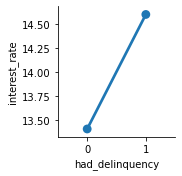

In [23]:
# month_since_last_delinquency: month to dummy variable
loan["month_since_last_delinquency"] = loan["month_since_last_delinquency"].apply(lambda x: 0 if np.isnan(x) else 1)
loan = loan.rename(columns={"month_since_last_delinquency" : "had_delinquency"})

# check contribution of the variable to interest rate
i = sns.PairGrid(data=loan, x_vars=["had_delinquency"], y_vars=["interest_rate"])
i.map(sns.pointplot)

**revolving_ratio** has several outliers, I'll replace them as well as missing values with mean. Since there are huge sample compared to outliers, mean will not affected by them in a substantial degree. Thus, we'll use sample mean that includes the outliers. 

<AxesSubplot:xlabel='revolving_ratio'>

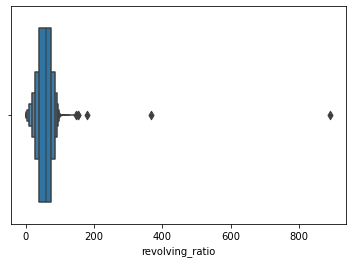

In [24]:
# check outliers
sns.boxenplot(data=loan, x="revolving_ratio")


In [25]:
# revolving_ratio: replace two outliers and missing values with mean
loan.loc[loan["revolving_ratio"]>100,'revolving_ratio'] = loan["revolving_ratio"].mean()
loan["revolving_ratio"].fillna(value=loan["revolving_ratio"].mean(), inplace=True)


**employer/job_title** has 163396 (~48%) unique values. Encode it as a binary variable that indiciate whether the borrower is employed or not.

In [26]:
# employer/job_title: categorical to dummy
loan["employer/job_title"] = loan["employer/job_title"].apply(lambda x: 0 if pd.isnull(x) else 1)
loan = loan.rename(columns={"employer/job_title" : "is_employed"})

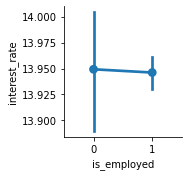

In [27]:
# check relationship between the variable and interest rate
i = sns.PairGrid(data=loan, x_vars=["is_employed"], y_vars=["interest_rate"])
i.map(sns.pointplot)

Interest rates are extremely similar across all employment lengths. So we are going to drop the **years_employed** column.

<AxesSubplot:xlabel='years_employed', ylabel='interest_rate'>

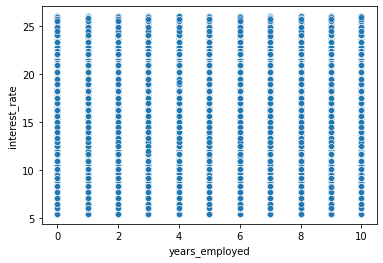

In [28]:
# check contribution of years_employed to interest_rate
sns.scatterplot(data=loan, x="years_employed", y="interest_rate")

In [29]:
# drop years_employed
loan = loan.drop(columns=["years_employed"])

Encode **state_of_borrower** into a dummy variable, indicating if the borrower comes from those states that have unusual interest rates.

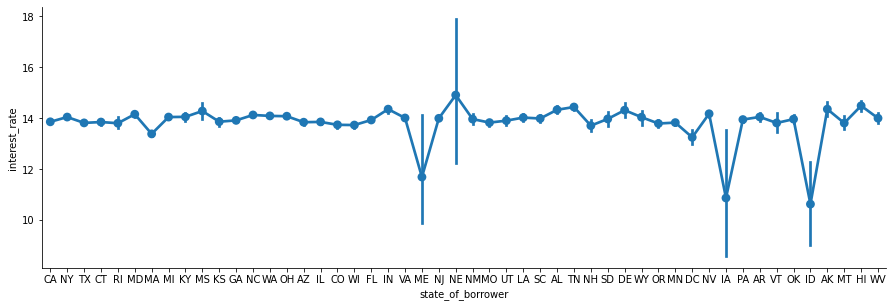

In [30]:
# check contribution of state_of_borrower to interest_rate
i = sns.PairGrid(data=loan, x_vars=["state_of_borrower"], y_vars=["interest_rate"])
i.map(sns.pointplot)
i.fig.set_size_inches(18,5)

In [31]:
# encode state_of_borrower into is_unusual_state
states = ["ME", "NE", "IA", "ID"]
loan["state_of_borrower"] = loan["state_of_borrower"].apply(lambda x: 1 if x in states else 0)
loan = loan.rename(columns={"state_of_borrower" : "is_unusual_state"})

**borrower's_annual_income** is positively skewed. Instead of using mean value, we'll use median to interpolate missing values. 

<AxesSubplot:xlabel="borrower's_annual_income">

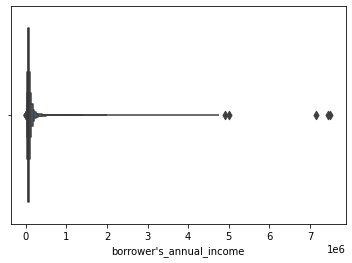

In [32]:
sns.boxenplot(data=loan, x="borrower\'s_annual_income")

In [33]:
loan["borrower\'s_annual_income"] = loan.fillna(loan["borrower\'s_annual_income"].median())

**loan_subgrade** is negatively skewed. Instead of using mean, use median to interpolate missing values. 

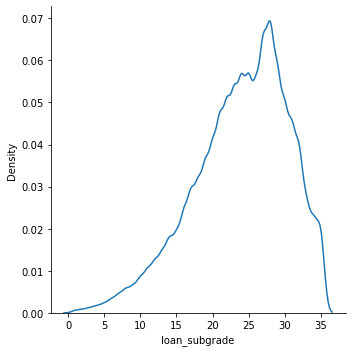

In [34]:
# check distribution
sns.displot(data=loan, x="loan_subgrade", kind="kde")


In [35]:
loan["loan_subgrade"] = loan.fillna(loan["loan_subgrade"].median())

### Build, Tune and Test Models

I will build three models and pick the one with best performance (in term of root-mean-square error, RMSE): **linear regression**- a linear regression method, **kernal svm** - a non-linear regression method, and **random forest** - a tree-based method.

In [36]:
# normalize
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer

# models
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor

# model evaluation
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score


In [37]:
# define a function that compute RMSE for testing, cv, and training datasets
def RMSEs(y_test, y_pred, model, X_train, y_train):
    # test
    RMSE_test = mean_squared_error(y_test, y_pred, squared=False)
    print(f"Testing set RMSE:", RMSE_test)
    
    # cv
    MSE_CV_scores = - cross_val_score(model, X_train, y_train, cv=10, 
                                  scoring='neg_mean_squared_error', 
                                  n_jobs=-1) 
    RMSE_CV = (MSE_CV_scores.mean())**(1/2)
    print(f"CV RMSE:", RMSE_CV)
    
    # train
    RMSE_train = mean_squared_error(y_train, model.predict(X_train), squared=False)
    print(f"Training set RMSE:",RMSE_train)

#### Linear Regression

In [38]:
# standardized dataset
scaler = StandardScaler()
sd_loan = pd.DataFrame(data=scaler.fit_transform(loan),
                       columns=loan.columns)

# split into X and y
sd_X = sd_loan.drop(columns=["interest_rate"])
sd_y = sd_loan["interest_rate"]

# split into train and test
sd_train_x, sd_test_x, sd_train_y, sd_test_y = train_test_split(sd_X, sd_y, test_size=0.3, random_state=42)

In [39]:
# fit model
lr = LinearRegression()
lr.fit(sd_train_x, sd_train_y)
y_lr = lr.predict(sd_test_x)


Evaluate and Tune the model by comparing three RMSE's.

In [40]:
RMSEs(sd_test_y, y_lr, lr, sd_train_x, sd_train_y)

Testing set RMSE: 1.1376712706703604e-14
CV RMSE: 8.228818808816091e-15
Training set RMSE: 1.1377738346990726e-14


Training set RMSE is larger than CV RMSE, meaning there is no problem of overfitting. CV RMSE is way smaller than Testing set RMSE, which is not showing a sign of underfitting. To summary, the model has decent generalization capability. 

Normalize the RMSE by **RMSE/(max(DV)-min(DV))** so to compare it with other models.

In [41]:
# calculate normalized rmse for testing dataset
RMSE = mean_squared_error(sd_test_y, y_lr, squared=False)
NRMSE = RMSE/(sd_y.max()-sd_y.min())
print(f"Normalized RMSE:", NRMSE)

Normalized RMSE: 2.413110320999204e-15


#### SVM Regression

In [42]:
# normalized dataset
scaler = Normalizer()
nm_loan = pd.DataFrame(data=scaler.fit_transform(loan),
                       columns=loan.columns)

nm_X = nm_loan.drop(columns=["interest_rate"])
nm_y = nm_loan["interest_rate"]
nm_train_x, nm_test_x, nm_train_y, nm_test_y = train_test_split(nm_X, nm_y, test_size=0.3, random_state=42)

In [43]:
# fit and score SVM model
sv = SVR(kernel="rbf", gamma=0.7)
sv.fit(nm_train_x, nm_train_y)
y_sv = sv.predict(nm_test_x)


Evaluate and Tune the model by comparing three RMSE's.

In [44]:
RMSEs(nm_test_y, y_sv, sv, nm_train_x, nm_train_y)

Testing set RMSE: 0.006109239745112746
CV RMSE: 0.0060945747226543315
Training set RMSE: 0.006109032949949878


Three RMSE's is about the same, which indicates decent generalization ability of the model.

In [45]:
# calculate normalized rmse for testing dataset
RMSE = mean_squared_error(nm_test_y, y_sv, squared=False)
NRMSE = RMSE/(nm_y.max()-nm_y.min())
print(f"Normalized RMSE:", NRMSE)

Normalized RMSE: 0.4532963278879987


#### Random Forest Regression

No normalization or standardization required.

In [46]:
# prepare x and y
X = loan.drop(columns=["interest_rate"])
y = loan["interest_rate"]
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)

In [47]:
# fit and score Random Forest model
rfr = RandomForestRegressor(max_depth=3)
rfr.fit(train_x, train_y)
y_rfr = rfr.predict(test_x)


Evaluate and Tune the model by comparing three RMSE's.

In [48]:
RMSEs(test_y, y_rfr, rfr, train_x, train_y)

Testing set RMSE: 0.6628671728370041
CV RMSE: 0.6569620070994064
Training set RMSE: 0.6640636405076846


With default model setting, training set RMSE is smaller than CV set RMSE, meaning overfitting. Limit max_depth to reduce complexity. The resulting model has similar RMSE's across three datasets. 

In [49]:
# calculate normalized rmse for testing dataset
RMSE = mean_squared_error(test_y, y_rfr, squared=False)
NRMSE = RMSE/(y.max()-y.min())
print(f"Normalized RMSE:", NRMSE)

Normalized RMSE: 0.03211565759869206


### Write-Up

Giving that all of the three models have good generalization capability, **Linear Regression has the minimun RMSE on testing dataset.** We may assume that there is a linear relationship between the predictors and interest rate and Linear Regression seems to be a good model for predicting interest rate. If so, Linear Regression also tells importance of each feature, known as *high interpreterbility*.